In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib

In [2]:
# Load Data
pokemon_df = pd.read_csv("../data/pokemon.csv")
combats_df = pd.read_csv("../data/combats.csv")

# Quick Look
pokemon_df.head()

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False
4,5,Charmander,Fire,NaN,39,52,43,60,50,65,1,False


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        800 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      414 non-null    object
 4   HP          800 non-null    int64 
 5   Attack      800 non-null    int64 
 6   Defense     800 non-null    int64 
 7   Sp. Atk     800 non-null    int64 
 8   Sp. Def     800 non-null    int64 
 9   Speed       800 non-null    int64 
 10  Generation  800 non-null    int64 
 11  Legendary   800 non-null    bool  
dtypes: bool(1), int64(8), object(3)
memory usage: 69.7+ KB


<Axes: title={'center': 'Distribution of Primary Types'}, xlabel='Type 1'>

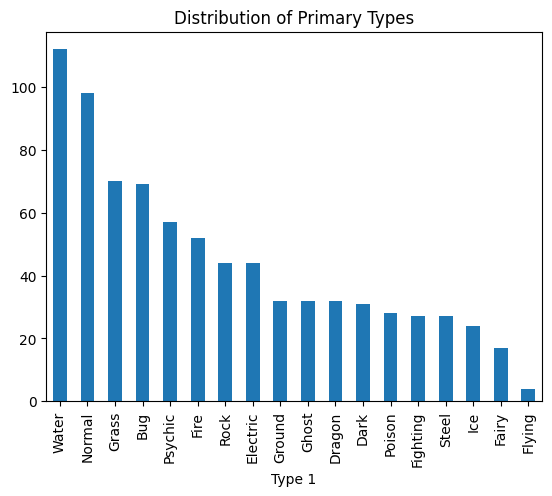

In [3]:
# Basic EDA
pokemon_df.info()
pokemon_df.describe()
pokemon_df["Type 1"].value_counts().plot(kind="bar", title="Distribution of Primary Types")

In [4]:
# Merge Combat Data with Pokemon Stats

# Rename columns for merging clarity
pokemon_df = pokemon_df.rename(columns={"#": "ID"})
pokemon_df = pokemon_df.set_index("ID")

# Merge player 1 and player 2 stats
def get_features(row):
    p1 = pokemon_df.loc[row["First_pokemon"]]
    p2 = pokemon_df.loc[row["Second_pokemon"]]
    features = p1[["HP", "Attack", "Defense", "Sp. Atk", "Sp. Def", "Speed"]].values.tolist() + \
               p2[["HP", "Attack", "Defense", "Sp. Atk", "Sp. Def", "Speed"]].values.tolist()
    return pd.Series(features)

feature_df = combats_df.apply(get_features, axis=1)
feature_df.columns = [
    "P1_HP", "P1_Atk", "P1_Def", "P1_SpAtk", "P1_SpDef", "P1_Spd",
    "P2_HP", "P2_Atk", "P2_Def", "P2_SpAtk", "P2_SpDef", "P2_Spd"
]

# Add target label
feature_df["Winner"] = combats_df["Winner"]
feature_df["Label"] = (feature_df["Winner"] == combats_df["First_pokemon"]).astype(int)  # 1 if P1 wins, else 0

In [5]:
# Preprocessing
X = feature_df.drop(columns=["Winner", "Label"])
y = feature_df["Label"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.89      0.91      0.90      5247
           1       0.89      0.88      0.88      4753

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



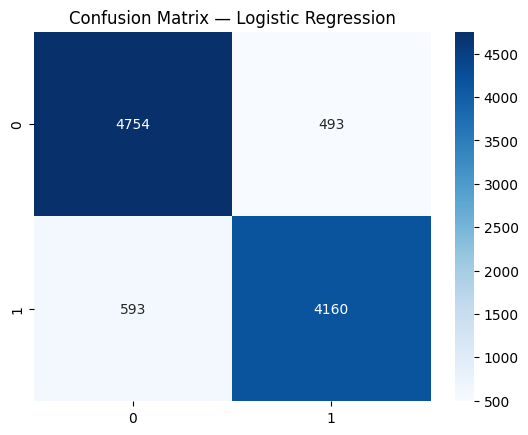

In [6]:
# Model Training — Logistic Regression (Baseline)
lr = LogisticRegression()
lr.fit(X_train_scaled, y_train)

# Evaluation
y_pred_lr = lr.predict(X_test_scaled)
print("Logistic Regression Report:\n", classification_report(y_test, y_pred_lr))
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix — Logistic Regression")
plt.show()

Random Forest Report:
               precision    recall  f1-score   support

           0       0.96      0.95      0.95      5247
           1       0.94      0.95      0.95      4753

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



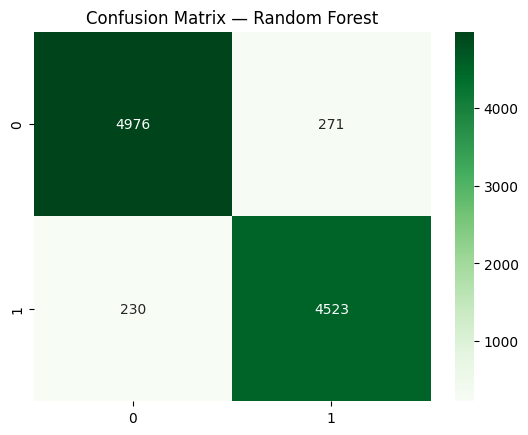

In [7]:
# Model Training — Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
print("Random Forest Report:\n", classification_report(y_test, y_pred_rf))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix — Random Forest")
plt.show()


In [8]:
# Save the best model + scaler
joblib.dump(rf, "../models/model.pkl")
joblib.dump(scaler, "../models/scaler.pkl")
print("Model and scaler saved.")


Model and scaler saved.
